#Import Dependencies

In [1]:
import sys
sys.path.append('C:/Users/57lzhang.US04WW4008/PycharmProjects/AF')

In [2]:
from util import util, model_util
import tensorflow as tf
from datetime import datetime
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
import numpy as np
import sklearn
from sklearn import metrics
print(tf.__version__)

2.3.1


#Training with LSTM

##Load data

In [ ]:
# load training data
train_data_file_path = "C:/Users/57lzhang.US04WW4008/Desktop/Afib/Afib data/Afib ECG data/training2017/"
raw_signals, raw_labels = util.data_mining(train_data_file_path)
signals, labels = util.generate_seg_data(raw_signals, raw_labels, seg_len=9000)
signals, labels = util.preprocessing(signals, labels, timedistributed=True)
train_signals, train_labels, val_signals, val_labels = util.split_shuffle_dataset(signals, labels, 0.9)
print('train_signal shape:', train_signals.shape)
print('train_label shape:', train_labels.shape)
print("\nIn training data:") 
util.count_labels(train_labels)
print("\nIn validation data:")
util.count_labels(val_labels)

train_signal shape: (7425, 3, 1250, 1)
train_label shape: (7425, 1)

In training data:
There are 4430 NSR labels
There are 653 AF labels
There are 2342 Other Arrhythmia labels

In validation data:
There are 502 NSR labels
There are 62 AF labels
There are 261 Other Arrhythmia labels


(502, 62, 261)

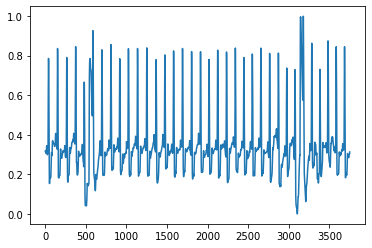

In [ ]:
import matplotlib.pyplot as plt
plt.plot(train_signals[2].reshape([3750,1]))

In [ ]:
# load testing data
test_data_file_path = "C:/Users/57lzhang.US04WW4008/Desktop/Afib/Afib data/Afib ECG data/validation/"
test_raw_signals, test_raw_labels = util.data_mining(test_data_file_path)
test_signals, test_labels = util.generate_seg_data(test_raw_signals, test_raw_labels, seg_len=9000)
test_signals, test_labels = util.preprocessing(test_signals, test_labels, timedistributed=True)
print('test_signal shape:', test_signals.shape)
print('test_label shape:', test_labels.shape)
print("\nIn test data:") 
util.count_labels(test_labels)

test_signal shape: (276, 3, 1250, 1)
test_label shape: (276, 1)

In test data:
There are 150 NSR labels
There are 47 AF labels
There are 79 Other Arrhythmia labels


(150, 47, 79)

##TF Pipeline

In [ ]:
# tensorflow pipeline
## extraction
train_dataset = tf.data.Dataset.from_tensor_slices((train_signals, train_labels))
val_dataset = tf.data.Dataset.from_tensor_slices((val_signals, val_labels))
## loading
batch_size = 32
train_dataset = train_dataset.cache()
train_dataset = train_dataset.shuffle(2048).repeat().batch(batch_size, drop_remainder=True)
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
val_dataset = val_dataset.repeat().batch(batch_size, drop_remainder=True)

##Model

In [ ]:
#cnn + lstm model
model = model_util.cnn_lstm((3,1250,1), classes=3)
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 3, 1250, 1)]      0         
_________________________________________________________________
time_distributed (TimeDistri (None, 3, 1216)           9776      
_________________________________________________________________
bidirectional (Bidirectional (None, 3, 64)             319744    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 32)                10368     
_________________________________________________________________
dense (Dense)                (None, 3)                 99        
Total params: 339,987
Trainable params: 339,715
Non-trainable params: 272
_________________________________________________________________


In [ ]:
model = model_util.resnet18_lstm(3, 32, 16, 1250, classes=3)
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

In [ ]:
model.summary()

##Callbacks

In [ ]:
# callbacks
log_dir = r"C:\Users\57lzhang.US04WW4008\Desktop\Afib\Afib data\logs\fit\\" + \
          datetime.now().strftime("%Y%m%d-%H%M%S") + "resnet"

## confusion matrix callback
def log_confusion_matrix(epoch, logs):
    # Use the model to predict the values from the test_images.
    
    test_pred_raw = model.predict(val_signals)

    test_pred = np.argmax(test_pred_raw, axis=1)
    test_labels = val_labels.reshape([len(val_labels)])
    # Calculate the confusion matrix using sklearn.metrics
    cm = sklearn.metrics.confusion_matrix(test_labels, test_pred)

    figure = model_util.plot_confusion_matrix(cm, class_names=class_names, normalize=True)
    cm_image = model_util.plot_to_image(figure)

    # Log the confusion matrix as an image summary.
    with file_writer_cm.as_default():
        tf.summary.image("Confusion Matrix", cm_image, step=epoch)

class_names = ['NO Afib','Afib','Others']
file_writer_cm = tf.summary.create_file_writer(log_dir + '/cm')
cm_callback = tf.keras.callbacks.LambdaCallback(on_epoch_end=log_confusion_matrix)

## tensorboard callback
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

## checkpoint callback
filepath = r"C:\Users\57lzhang.US04WW4008\Desktop\Afib\Afib data\models\resnet-{epoch:02d}-{loss:.4f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='auto')

## learning rate decay callback
lr_schedule = tf.keras.callbacks.LearningRateScheduler(model_util.decay)

callbacks_list = [tensorboard_callback, cm_callback, checkpoint, lr_schedule]

##Model Training

In [ ]:
#model training
CLASS_WEIGHTS = util.class_weights(train_labels)

model.fit(train_dataset,
          epochs=200,
          steps_per_epoch=len(list(train_signals))//batch_size,
          verbose=1,
          validation_data=val_dataset,
          validation_steps=len(list(val_signals))//batch_size,
          callbacks=callbacks_list,
          class_weight=CLASS_WEIGHTS)

#Training with Autoencoder

In [ ]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Conv1D, BatchNormalization, Input, Add, Activation, \
    MaxPooling1D, Dropout, Flatten, TimeDistributed, Bidirectional, Dense, LSTM, ZeroPadding1D, \
    AveragePooling1D, Conv1DTranspose, GlobalMaxPooling1D, Concatenate, Permute, Dot, Multiply, RepeatVector, \
    Lambda, Average

In [ ]:
import os
os.chdir(r"C:\Users\57lzhang.US04WW4008\Desktop\Afib\Afib data\models")
ecg_encoder = tf.keras.models.load_model('ECG_Encoder.h5')
conv_encoder_clone = tf.keras.models.clone_model(ecg_encoder)

In [ ]:
def encoder_lstm(input_shape=(3,1250,1), classes=3):
  X_input = Input(shape=input_shape)
  X = TimeDistributed(conv_encoder_clone)(X_input)
  X = TimeDistributed(Flatten())(X)
  X = Bidirectional(LSTM(32, return_sequences=True))(X)
  X = Bidirectional(LSTM(16))(X)
  X = Dense(classes, activation='softmax')(X)

  model = Model(inputs=[X_input], outputs=X)

  return model

In [ ]:
model = encoder_lstm(input_shape=(3,1250,1), classes=3)

In [ ]:
model.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 3, 1250, 1)]      0         
_________________________________________________________________
time_distributed_9 (TimeDist (None, 3, 1250, 16)       53328     
_________________________________________________________________
time_distributed_10 (TimeDis (None, 3, 20000)          0         
_________________________________________________________________
bidirectional_9 (Bidirection (None, 3, 64)             5128448   
_________________________________________________________________
bidirectional_10 (Bidirectio (None, 32)                10368     
_________________________________________________________________
dense_4 (Dense)              (None, 3)                 99        
Total params: 5,192,243
Trainable params: 5,138,915
Non-trainable params: 53,328
_______________________________________

In [ ]:
conv_encoder_clone.trainable = False
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

In [ ]:
CLASS_WEIGHTS = util.class_weights(train_labels)

model.fit(train_dataset,
          epochs=200,
          steps_per_epoch=len(list(train_signals))//batch_size,
          verbose=1,
          validation_data=val_dataset,
          validation_steps=len(list(val_signals))//batch_size,
          callbacks=callbacks_list,
          class_weight=CLASS_WEIGHTS)

#Training with Spectrogram

In [3]:
train_data_file_path = "C:/Users/57lzhang.US04WW4008/Desktop/Afib/Afib data/Afib ECG data/training2017/"
raw_signals, raw_labels = util.data_mining(train_data_file_path)
signals, labels = util.generate_seg_data(raw_signals, raw_labels, seg_len=9000)

In [47]:
def get_spectrogram(signal):
  # Zero padding if signals length is less than 9000
  zero_padding = tf.zeros([9000] - tf.shape(signal))
  signal = tf.cast(signal, tf.float32)
  equal_length = tf.concat([signal, zero_padding], 0)
  spectrogram = tf.signal.stft(equal_length, frame_length=1024, frame_step=128)
  spectrogram = tf.abs(spectrogram)
  
  return spectrogram[:,:200]

In [48]:
spectrogram.numpy().shape

(63, 200)

C:\Users\57lzhang.US04WW4008\Anaconda3\lib\site-packages\matplotlib\text.py:1150: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


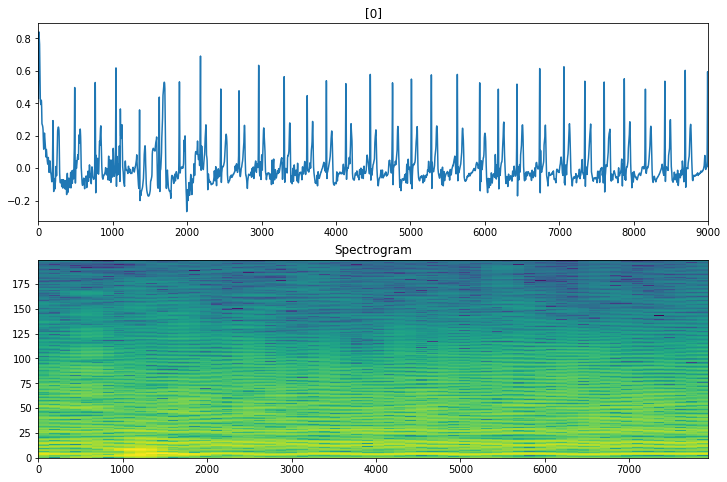

In [35]:
#inspect the spectrogram from one sample
spectrogram = get_spectrogram(signals[0])
spectrogram.shape

import matplotlib.pyplot as plt

def plot_spectrogram(spectrogram, ax):
  # Convert to frequencies to log scale and transpose so that the time is
  # represented in the x-axis (columns).
  log_spec = np.log(spectrogram.T)
  height = log_spec.shape[0]
  X = np.arange(9000-1024, step=128)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)


fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(signals[0].shape[0])
axes[0].plot(timescale, signals[0])
axes[0].set_title(labels[1])
axes[0].set_xlim([0, 9000])
plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.show()

In [37]:
def get_spectrogram_and_label(signal, label):
  spectrogram = get_spectrogram(signal)
  spectrogram = tf.expand_dims(spectrogram, -1)
  return spectrogram, label

In [38]:
train_signals, train_labels, val_signals, val_labels = util.split_shuffle_dataset(signals, labels, 0.9, seed=10)

In [39]:
print('train_signal shape:', train_signals.shape)
print('train_label shape:', train_labels.shape)
print("\nIn training data:") 
util.count_labels(train_labels)
print("\nIn validation data:")
util.count_labels(val_labels)

train_signal shape: (7425, 9000)
train_label shape: (7425, 1)

In training data:
There are 4443 NSR labels
There are 642 AF labels
There are 2340 Other Arrhythmia labels

In validation data:
There are 489 NSR labels
There are 73 AF labels
There are 263 Other Arrhythmia labels


(489, 73, 263)

In [40]:
# tensorflow pipeline
## extraction
train_dataset = tf.data.Dataset.from_tensor_slices((train_signals, train_labels))
val_dataset = tf.data.Dataset.from_tensor_slices((val_signals, val_labels))
train_dataset = train_dataset.map(get_spectrogram_and_label, num_parallel_calls=tf.data.experimental.AUTOTUNE)
val_dataset = val_dataset.map(get_spectrogram_and_label, num_parallel_calls=tf.data.experimental.AUTOTUNE)

## loading
batch_size = 32
train_dataset = train_dataset.cache()
train_dataset = train_dataset.shuffle(2048).repeat().batch(batch_size, drop_remainder=True)
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
val_dataset = val_dataset.repeat().batch(batch_size, drop_remainder=True)

In [41]:
train_dataset

<PrefetchDataset shapes: ((32, 63, 200, 1), (32, 1)), types: (tf.float32, tf.int32)>

In [64]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Conv1D, BatchNormalization, Input, Add, Activation, \
    MaxPooling1D, Dropout, Flatten, TimeDistributed, Bidirectional, Dense, LSTM, ZeroPadding1D, \
    AveragePooling1D, Conv1DTranspose, GlobalMaxPooling1D, Concatenate, Permute, Dot, Multiply, RepeatVector, \
    Lambda, Average

# tensorflow input shape = (m, 69, 129, 1)
# Better to experiment with different filter size and strides
## Experiment with batch normalization to see if it improve accuracy
#clear history if necessary
tf.keras.backend.clear_session()
model = tf.keras.Sequential([
    #1st Conv2D
    tf.keras.layers.Input(shape=(63,200,1)),
    tf.keras.layers.experimental.preprocessing.Normalization(),
    tf.keras.layers.Conv2D(8, (1, 1), strides=(1, 1), 
                           activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2),strides=(2, 2)),
    #tf.keras.layers.Dropout(0.2),
    #2nd Conv2D
    tf.keras.layers.Conv2D(16, (3, 3), strides=(1, 1),
                           activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2),strides=(2, 2)),
    #tf.keras.layers.Dropout(0.2),
    #3rd Conv2D
    tf.keras.layers.Conv2D(32, (3, 3), strides=(1, 1),
                           activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2),strides=(2, 2)),
    tf.keras.layers.Dropout(0.2),
    #4th Conv2D
    tf.keras.layers.Conv2D(64, (3, 3), strides=(1, 1),
                           activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2),strides=(2, 2)),
    tf.keras.layers.Dropout(0.2),
    #5th Conv2D
    tf.keras.layers.Conv2D(16, (1, 1), strides=(1, 1),
                           activation='relu'),
    #Full connection layer
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(3, activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 63, 200, 1)        3         
_________________________________________________________________
conv2d (Conv2D)              (None, 63, 200, 8)        16        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 31, 100, 8)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 29, 98, 16)        1168      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 49, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 47, 32)        4640      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 6, 23, 32)         0

In [65]:
val_spectrogram = []
for val_signal in val_signals:
  val_spectrogram.append(get_spectrogram(val_signal).numpy())

val_signals_cm = np.array(val_spectrogram)
val_signals_cm = tf.expand_dims(val_signals_cm, -1)
val_signals_cm.shape

TensorShape([825, 63, 200, 1])

In [66]:
# callbacks
log_dir = r"C:\Users\57lzhang.US04WW4008\Desktop\Afib\Afib data\logs\fit\\" + \
          datetime.now().strftime("%Y%m%d-%H%M%S") + "resnet"

## confusion matrix callback
def log_confusion_matrix(epoch, logs):
    # Use the model to predict the values from the test_images.
    
    test_pred_raw = model.predict(val_signals_cm)

    test_pred = np.argmax(test_pred_raw, axis=1)
    test_labels = val_labels.reshape([len(val_labels)])
    # Calculate the confusion matrix using sklearn.metrics
    cm = sklearn.metrics.confusion_matrix(test_labels, test_pred)

    figure = model_util.plot_confusion_matrix(cm, class_names=class_names, normalize=True)
    cm_image = model_util.plot_to_image(figure)

    # Log the confusion matrix as an image summary.
    with file_writer_cm.as_default():
        tf.summary.image("Confusion Matrix", cm_image, step=epoch)

class_names = ['NSR','Afib','Others']
file_writer_cm = tf.summary.create_file_writer(log_dir + '/cm')
cm_callback = tf.keras.callbacks.LambdaCallback(on_epoch_end=log_confusion_matrix)

## tensorboard callback
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

## checkpoint callback
filepath = r"C:\Users\57lzhang.US04WW4008\Desktop\Afib\Afib data\models\resnet-{epoch:02d}-{loss:.4f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='auto')

## learning rate decay callback
lr_schedule = tf.keras.callbacks.LearningRateScheduler(model_util.decay)

callbacks_list = [tensorboard_callback, cm_callback, checkpoint, lr_schedule]

In [67]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [68]:
#model training
CLASS_WEIGHTS = util.class_weights(train_labels)

model.fit(train_dataset,
          epochs=200,
          steps_per_epoch=len(list(train_signals))//batch_size,
          verbose=1,
          validation_data=val_dataset,
          validation_steps=len(list(val_signals))//batch_size,
          callbacks=callbacks_list,
          class_weight=CLASS_WEIGHTS)

There are 4443 NSR labels
There are 642 AF labels
There are 2340 Other Arrhythmia labels
Epoch 1/200
229/232 [============================>.] - ETA: 0s - loss: 0.2045 - accuracy: 0.3264
Epoch 00001: loss improved from inf to 0.20441, saving model to C:\Users\57lzhang.US04WW4008\Desktop\Afib\Afib data\models\resnet-01-0.2044.hdf5
232/232 [==============================] - 4s 19ms/step - loss: 0.2044 - accuracy: 0.3264 - val_loss: 1.0705 - val_accuracy: 0.4112
Epoch 2/200
230/232 [============================>.] - ETA: 0s - loss: 0.1827 - accuracy: 0.4564
Epoch 00002: loss improved from 0.20441 to 0.18256, saving model to C:\Users\57lzhang.US04WW4008\Desktop\Afib\Afib data\models\resnet-02-0.1826.hdf5
232/232 [==============================] - 4s 16ms/step - loss: 0.1826 - accuracy: 0.4576 - val_loss: 0.8585 - val_accuracy: 0.6325
Epoch 3/200
231/232 [============================>.] - ETA: 0s - loss: 0.1534 - accuracy: 0.5900
Epoch 00003: loss improved from 0.18256 to 0.15333, saving mod